# Cleaning anomalies in time series per region slug



## Load  libraries

In [20]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

#### Run single

In [80]:
from src.runners.clean import _run_single 

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


2021-04-22 13:57:20.865 | INFO     | src.runners.clean:_run_single:696 - ... here we go vitoria...

2021-04-22 13:57:20.866 | DEBUG    | src.runners.clean:_reading_data:607 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('vitoria')
        
2021-04-22 13:57:22.468 | DEBUG    | src.runners.clean:_c_param:277 - C avg: 0.5482863258149389
2021-04-22 13:57:22.472 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 13:57:22.473 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 13:57:22.473 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 13:57:22.475 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is tr

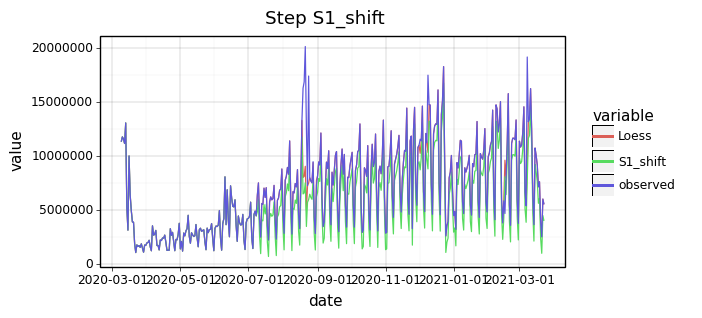

2021-04-22 13:57:23.885 | DEBUG    | src.runners.clean:_run_step:681 - ... step done ...
2021-04-22 13:57:23.892 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 13:57:23.892 | INFO     | src.runners.clean:_run_step:636 - Target variable: S1_shift 

2021-04-22 13:57:23.893 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 13:57:23.895 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

<ggplot: (8793659620873)>


2021-04-22 13:57:24.833 | DEBUG    | src.runners.clean:_run_shift_grid:345 - Total combinations: 25
2021-04-22 13:57:25.094 | DEBUG    | src.runners.clean:_initial_shift_date:422 - Shift found at 2020-12-08 00:00:00
2021-04-22 13:57:25.098 | DEBUG    | src.runners.clean:_shift_ts:445 - 

2021-04-22 13:57:25.101 | DEBUG    | src.runners.clean:_shift_ts:446 - Center point: -845205.7342388891
../src/runners/clean.py:450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


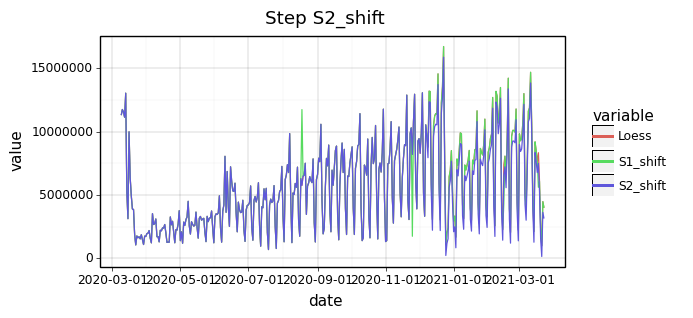

2021-04-22 13:57:25.493 | DEBUG    | src.runners.clean:_run_step:681 - ... step done ...


<ggplot: (8793663830349)>


2021-04-22 13:57:25.895 | DEBUG    | src.runners.clean:_write_missing:614 - ... writing anomalies file ...


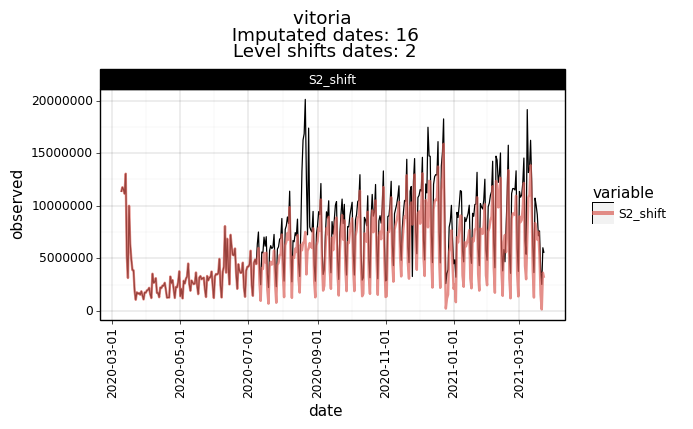

<ggplot: (8793658280585)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_vitoria.pdf
2021-04-22 13:57:27.751 | INFO     | src.runners.clean:_run_single:769 - ... vitoria done ...



In [81]:
daily, weekly = _run_single(region_slug='vitoria', 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            c_metric = 'avg', 
                            print_report = False, 
                            print_plot = True)

In [61]:
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

In [64]:
daily.head(3)
gg = (p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))
#gg 

In [65]:
weekly.head(3)
gg = (p9.ggplot(weekly, p9.aes(x = 'date_min', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))
# gg

#### Run by batch

In [82]:
from src.runners.clean import _run_batch 

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [151]:
_run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona", 
          c_metric = 'max')

2021-04-22 15:52:30.948 | INFO     | src.runners.clean:_run_batch:788 - TO DO regions  81
2021-04-22 15:52:30.949 | INFO     | src.runners.clean:_run_single:696 - ... here we go aguascalientes...

2021-04-22 15:52:30.952 | DEBUG    | src.runners.clean:_reading_data:607 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('aguascalientes')
        


aguascalientes


2021-04-22 15:52:33.581 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.0273899198125596
2021-04-22 15:52:33.585 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:52:33.586 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:52:33.586 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:52:33.588 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

arequipa


2021-04-22 15:52:39.190 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.3707797834677795
2021-04-22 15:52:39.194 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:52:39.194 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:52:39.195 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:52:39.196 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

barranquilla


2021-04-22 15:52:45.549 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.76668667025904
2021-04-22 15:52:45.553 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:52:45.554 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:52:45.554 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:52:45.556 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

belem


2021-04-22 15:52:51.984 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.6751306885065211
2021-04-22 15:52:51.988 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:52:51.989 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:52:51.989 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:52:51.990 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

belohorizonte


2021-04-22 15:52:58.325 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.7932268803995419
2021-04-22 15:52:58.328 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:52:58.329 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:52:58.330 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:52:58.331 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

bogota


2021-04-22 15:53:04.003 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.7885534354346917
2021-04-22 15:53:04.007 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:04.008 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:04.008 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:04.010 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

brasilia


2021-04-22 15:53:09.743 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.045577611833902
2021-04-22 15:53:09.746 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:09.747 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:09.748 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:09.749 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

bucaramanga


2021-04-22 15:53:15.283 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.6872269818077374
2021-04-22 15:53:15.287 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:15.287 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:15.288 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:15.289 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

buenosaires


2021-04-22 15:53:21.128 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.9098498045084976
2021-04-22 15:53:21.131 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:21.132 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:21.133 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:21.134 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

cali


2021-04-22 15:53:26.567 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.4587580136087392
2021-04-22 15:53:26.570 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:26.571 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:26.572 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:26.573 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

campinas


2021-04-22 15:53:35.217 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.8807937888708207
2021-04-22 15:53:35.221 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:35.221 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:35.222 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:35.223 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

cartagena


2021-04-22 15:53:42.343 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.5510305787633392
2021-04-22 15:53:42.347 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:42.348 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:42.348 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:42.349 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

cordoba


2021-04-22 15:53:47.882 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.6189154013154357
2021-04-22 15:53:47.885 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:47.886 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:47.888 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:47.889 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-22 15:53:47.916 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

country_argentina


2021-04-22 15:53:54.298 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.2809406370453256
2021-04-22 15:53:54.302 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:54.302 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:54.303 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:54.304 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-22 15:53:54.334 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

country_barbados


2021-04-22 15:53:59.465 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.9579304881178845
2021-04-22 15:53:59.468 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:53:59.469 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:53:59.470 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:53:59.473 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

country_brazil


2021-04-22 15:54:05.061 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:54:05.065 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:05.066 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:05.066 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:05.067 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021

country_chile


2021-04-22 15:54:10.891 | DEBUG    | src.runners.clean:_c_param:277 - C max: 4.142744523852838
2021-04-22 15:54:10.895 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:10.896 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:10.896 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:10.897 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

country_colombia


2021-04-22 15:54:16.493 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.691574492443756
2021-04-22 15:54:16.497 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:16.497 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:16.498 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:16.499 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

country_costa_rica


2021-04-22 15:54:22.707 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.6067585208477897
2021-04-22 15:54:22.711 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:22.711 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:22.712 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:22.713 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

country_dominican_republic


2021-04-22 15:54:28.954 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.3351452315716383
2021-04-22 15:54:28.958 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:28.959 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:28.959 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:28.961 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

country_ecuador


2021-04-22 15:54:34.121 | DEBUG    | src.runners.clean:_c_param:277 - C max: 2.0178491790094
2021-04-22 15:54:34.125 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:34.126 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:34.126 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:34.128 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

country_el_salvador


2021-04-22 15:54:40.530 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.983635178740892
2021-04-22 15:54:40.534 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:40.535 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:40.536 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:40.537 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

country_guatemala


2021-04-22 15:54:45.641 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.3497639329038027
2021-04-22 15:54:45.645 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:45.646 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:45.646 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:45.647 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

country_honduras


2021-04-22 15:54:51.207 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:54:51.211 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:51.211 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:51.212 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:51.213 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021

country_jamaica


2021-04-22 15:54:57.471 | DEBUG    | src.runners.clean:_c_param:277 - C max: 2.1973952336567217
2021-04-22 15:54:57.475 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:54:57.475 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:54:57.476 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:54:57.477 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

country_mexico


2021-04-22 15:55:04.968 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:55:04.971 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:04.972 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:04.973 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:04.974 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021

country_nicaragua


2021-04-22 15:55:10.382 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:55:10.386 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:10.386 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:10.387 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:10.388 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021

country_panama


2021-04-22 15:55:16.481 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:55:16.485 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:16.485 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:16.486 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:16.487 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021

country_paraguay


2021-04-22 15:55:21.902 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:55:21.906 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:21.906 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:21.907 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:21.908 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021

country_peru


2021-04-22 15:55:27.093 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:55:27.096 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:27.097 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:27.099 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:27.101 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021

country_trinidad_and_tobago


2021-04-22 15:55:32.176 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:55:32.180 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:32.180 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:32.181 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:32.182 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021

country_uruguay


2021-04-22 15:55:38.573 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3
2021-04-22 15:55:38.577 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:38.578 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:38.578 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:38.579 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-22 15:55:38.608 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

cucuta


2021-04-22 15:55:44.083 | DEBUG    | src.runners.clean:_c_param:277 - C max: 2.077252636557924
2021-04-22 15:55:44.086 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:44.087 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:44.087 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:44.089 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-22 15:55:44.117 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

cuenca


2021-04-22 15:55:49.172 | DEBUG    | src.runners.clean:_c_param:277 - C max: 3.1014910267983185
2021-04-22 15:55:49.175 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:49.176 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:49.177 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:49.180 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

curitiba


2021-04-22 15:55:54.434 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.5530162237918487
2021-04-22 15:55:54.438 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:55:54.438 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:55:54.439 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:55:54.440 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

fortaleza


2021-04-22 15:56:00.924 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.7847212471922886
2021-04-22 15:56:00.927 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:00.928 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:00.928 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:00.930 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

goiania


2021-04-22 15:56:06.319 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.6886402819581707
2021-04-22 15:56:06.322 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:06.323 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:06.323 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:06.325 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

guadalajara


2021-04-22 15:56:12.023 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.341901667057806
2021-04-22 15:56:12.026 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:12.027 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:12.028 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:12.029 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

guatemala


2021-04-22 15:56:18.321 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.6609323947431904
2021-04-22 15:56:18.325 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:18.326 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:18.326 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:18.328 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

guayaquil


2021-04-22 15:56:23.695 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.0869959841260328
2021-04-22 15:56:23.699 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:23.700 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:23.700 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:23.702 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

joaopessoa


2021-04-22 15:56:30.459 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.8329019561170704
2021-04-22 15:56:30.462 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:30.463 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:30.464 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:30.465 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

kingston


2021-04-22 15:56:35.763 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.4675734225846222
2021-04-22 15:56:35.767 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:35.768 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:35.768 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:35.770 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

leon


2021-04-22 15:56:41.154 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.6712063144721307
2021-04-22 15:56:41.157 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:41.158 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:41.159 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:41.160 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

lima


2021-04-22 15:56:46.747 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.3292364286255252
2021-04-22 15:56:46.751 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:46.752 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:46.754 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:46.756 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

maceio


2021-04-22 15:56:53.062 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.6694820447662065
2021-04-22 15:56:53.065 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:53.066 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:53.068 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:53.070 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

managua


2021-04-22 15:56:59.435 | DEBUG    | src.runners.clean:_c_param:277 - C max: 2.3062522483739114
2021-04-22 15:56:59.439 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:56:59.439 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:56:59.440 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:56:59.441 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

manaus


2021-04-22 15:57:04.860 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.8762962595307018
2021-04-22 15:57:04.865 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:04.866 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:04.866 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:04.867 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

medellin


2021-04-22 15:57:10.190 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.0561541424862373
2021-04-22 15:57:10.194 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:10.194 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:10.195 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:10.196 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

merida


2021-04-22 15:57:15.773 | DEBUG    | src.runners.clean:_c_param:277 - C max: 2.846122525561435
2021-04-22 15:57:15.777 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:15.778 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:15.779 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:15.782 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

mexicocity


2021-04-22 15:57:22.677 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.2739730879698026
2021-04-22 15:57:22.680 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:22.681 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:22.682 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:22.683 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

monterrey


2021-04-22 15:57:28.678 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.0541138630388942
2021-04-22 15:57:28.682 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:28.682 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:28.683 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:28.683 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

montevideo


2021-04-22 15:57:33.984 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.8200260736553959
2021-04-22 15:57:33.987 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:33.988 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:33.988 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:33.990 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-22 15:57:34.019 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

natal


2021-04-22 15:57:39.623 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.0880442257594305
2021-04-22 15:57:39.627 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:39.627 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:39.628 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:39.629 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

panamacity


2021-04-22 15:57:45.205 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.1945219445657078
2021-04-22 15:57:45.209 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:45.210 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:45.210 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:45.212 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

pereira


2021-04-22 15:57:51.371 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.3991602224679982
2021-04-22 15:57:51.374 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:51.375 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:51.376 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:51.377 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

porto_alergre


2021-04-22 15:57:56.973 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.5064590067301696
2021-04-22 15:57:56.977 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:57:56.977 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:57:56.978 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:57:56.979 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

pueble


2021-04-22 15:58:02.345 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.145334843552123
2021-04-22 15:58:02.349 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:02.349 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:02.351 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:02.354 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

queretaro


2021-04-22 15:58:07.688 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.0217022006577623
2021-04-22 15:58:07.691 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:07.692 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:07.694 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:07.696 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

quito


2021-04-22 15:58:13.020 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.4020956452000344
2021-04-22 15:58:13.023 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:13.024 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:13.025 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:13.025 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

recife


2021-04-22 15:58:18.292 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.7276713646191327
2021-04-22 15:58:18.296 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:18.297 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:18.297 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:18.299 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

riodejaneiro


2021-04-22 15:58:23.965 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.7051065215962252
2021-04-22 15:58:23.969 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:23.970 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:23.970 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:23.972 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

rosario


2021-04-22 15:58:29.282 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.6300638242855072
2021-04-22 15:58:29.286 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:29.287 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:29.287 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:29.289 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

salvador


2021-04-22 15:58:35.464 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.7570923944305465
2021-04-22 15:58:35.468 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:35.468 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:35.469 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:35.469 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

sanjose


2021-04-22 15:58:40.878 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.4722106991438355
2021-04-22 15:58:40.881 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:40.882 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:40.883 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:40.884 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

sanluispotosi


2021-04-22 15:58:47.359 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.6554248545597523
2021-04-22 15:58:47.363 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:47.364 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:47.364 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:47.366 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

sansalvador


2021-04-22 15:58:54.627 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.4512411316196725
2021-04-22 15:58:54.630 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:58:54.631 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:58:54.632 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:58:54.633 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

santacruzdelasierra


2021-04-22 15:59:00.730 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.2474824730113303
2021-04-22 15:59:00.735 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:00.736 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:00.736 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:00.738 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

santamarta


2021-04-22 15:59:06.963 | DEBUG    | src.runners.clean:_c_param:277 - C max: 5.851182967075816
2021-04-22 15:59:06.966 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:06.967 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:06.969 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:06.970 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

santiago


2021-04-22 15:59:12.431 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.7238798250564803
2021-04-22 15:59:12.434 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:12.435 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:12.436 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:12.437 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

santiagocaballeros


2021-04-22 15:59:17.954 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.4943365380804419
2021-04-22 15:59:17.958 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:17.959 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:17.959 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:17.960 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

2021-04-22 15:59:21.804 | INFO     | src.runners.clean:_run_single:769 - ... santiagocaballeros done ...

2021-04-22 15:59:21.805 | INFO     | src.runners.clean:_run_single:696 - ... here we go santodomingo...

2021-04-22 15:59:21.808 | DEBUG    | src.runners.clean:_reading_data:607 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('santodomingo')
        


santodomingo


2021-04-22 15:59:24.395 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.3523040362739855
2021-04-22 15:59:24.398 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:24.399 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:24.400 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:24.400 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

santos


2021-04-22 15:59:29.731 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.7896025576544832
2021-04-22 15:59:29.735 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:29.736 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:29.738 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:29.739 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

saojosedoscampos


2021-04-22 15:59:38.622 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.5223668037712927
2021-04-22 15:59:38.625 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:38.626 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:38.627 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:38.628 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

saoluis


2021-04-22 15:59:45.032 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.0670831789268076
2021-04-22 15:59:45.036 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:45.037 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:45.037 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:45.039 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

saopaulo


2021-04-22 15:59:50.897 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.9716867880970144
2021-04-22 15:59:50.901 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:50.902 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:50.902 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:50.904 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

sorocaba


2021-04-22 15:59:56.203 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.3518559706673363
2021-04-22 15:59:56.206 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 15:59:56.207 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 15:59:56.208 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 15:59:56.209 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

tegucigalpa


2021-04-22 16:00:03.292 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.4825062790341532
2021-04-22 16:00:03.296 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 16:00:03.297 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 16:00:03.297 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 16:00:03.299 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

teresina


2021-04-22 16:00:09.629 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.9721586604894438
2021-04-22 16:00:09.632 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 16:00:09.633 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 16:00:09.633 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 16:00:09.635 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

toluca


2021-04-22 16:00:15.095 | DEBUG    | src.runners.clean:_c_param:277 - C max: 1.0739196312627826
2021-04-22 16:00:15.098 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 16:00:15.099 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 16:00:15.100 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 16:00:15.101 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

torreon


2021-04-22 16:00:20.448 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.7849571168548051
2021-04-22 16:00:20.452 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 16:00:20.453 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 16:00:20.453 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 16:00:20.455 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

vitoria


2021-04-22 16:00:25.819 | DEBUG    | src.runners.clean:_c_param:277 - C max: 0.8880699427405386
2021-04-22 16:00:25.822 | DEBUG    | src.runners.clean:_run_step:635 - ... step start ...
2021-04-22 16:00:25.823 | INFO     | src.runners.clean:_run_step:636 - Target variable: observed 

2021-04-22 16:00:25.824 | DEBUG    | src.runners.clean:_find_anomalies:160 - 
... finding outliers ...
2021-04-22 16:00:25.825 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

../src/runners/clean.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

## Comparison: `min - max - avg`

### Daily

In [152]:
import pandas as pd
from siuba import *
df_min = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_min.csv")
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max.csv")
df_avg = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_avg.csv")

df_max = df_max[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_max', 
                       'tcp_clean':'tcp_max'}) 
df_min = df_min[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_min', 
                       'tcp_clean':'tcp_min'})
df_avg = df_avg[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_avg', 
                       'tcp_clean':'tcp_avg'})

In [153]:
print(df_min.shape)
print(df_max.shape)
print(df_avg.shape)

(30780, 6)
(30780, 6)
(30780, 6)


In [154]:
df_union = df_max \
    .merge(df_avg) \
    .merge(df_min)
df_union.describe()

,tci_observed,tcp_observed,tci_max,tcp_max,tci_avg,tcp_avg,tci_min,tcp_min
count,3.078000e+04,30780.000000,3.078000e+04,30780.000000,3.078000e+04,30780.000000,3.078000e+04,30780.000000
mean,3.871209e+07,-35.569059,2.477004e+07,-51.727259,2.484656e+07,-51.787728,2.461562e+07,-51.965774
std,1.511305e+08,50.823745,6.951377e+07,34.230560,6.975355e+07,34.384702,6.931817e+07,34.248786
min,1.392000e+03,-99.842676,0.000000e+00,-100.000000,0.000000e+00,-100.000000,0.000000e+00,-100.000000
25%,2.144112e+06,-69.761236,1.507495e+06,-74.784056,1.513536e+06,-74.740962,1.500417e+06,-74.974927
50%,6.960414e+06,-43.434787,5.341035e+06,-56.760671,5.262143e+06,-57.143573,5.288240e+06,-57.368880
75%,2.024936e+07,-13.987707,1.718479e+07,-36.094710,1.692585e+07,-36.696954,1.690002e+07,-36.253859
max,3.742041e+09,1060.720310,1.205369e+09,321.817546,1.205369e+09,302.952237,1.205369e+09,313.014336


In [155]:
df_union.to_csv("/home/soniame/private/daily_index_index.csv")

In [156]:
df_union[df_union.region_slug == 'aguascalientes']

,date,region_slug,tci_observed,tcp_observed,tci_max,tcp_max,tci_avg,tcp_avg,tci_min,tcp_min
0,2021-02-28,aguascalientes,1784194,21.971151,6.413892e+05,-56.153324,6.413892e+05,-56.153324,1.168184e+06,-20.140538
1,2020-11-29,aguascalientes,1674701,14.485986,5.318962e+05,-63.638489,5.318962e+05,-63.638489,1.058691e+06,-27.625704
2,2020-08-23,aguascalientes,3207350,119.261006,5.013062e+05,-65.729685,5.013062e+05,-65.729685,1.028101e+06,-29.716900
3,2020-08-09,aguascalientes,1476292,0.922341,3.334872e+05,-77.202134,3.334872e+05,-77.202134,8.602822e+05,-41.189349
4,2020-05-10,aguascalientes,588083,-59.797443,5.880830e+05,-59.797443,5.880830e+05,-59.797443,5.880830e+05,-59.797443
...,...,...,...,...,...,...,...,...,...,...
375,2020-11-04,aguascalientes,2088153,-26.297612,9.453482e+05,-66.633471,9.453482e+05,-66.633471,1.472143e+06,-48.039981
376,2020-09-23,aguascalientes,1849607,-34.717211,7.068022e+05,-75.053069,7.068022e+05,-75.053069,1.233597e+06,-56.459580
377,2021-02-24,aguascalientes,2327786,-17.839648,1.184981e+06,-58.175506,1.184981e+06,-58.175506,1.711776e+06,-39.582017
378,2020-11-18,aguascalientes,2651868,-6.401014,1.509063e+06,-46.736872,1.509063e+06,-46.736872,2.035858e+06,-28.143383


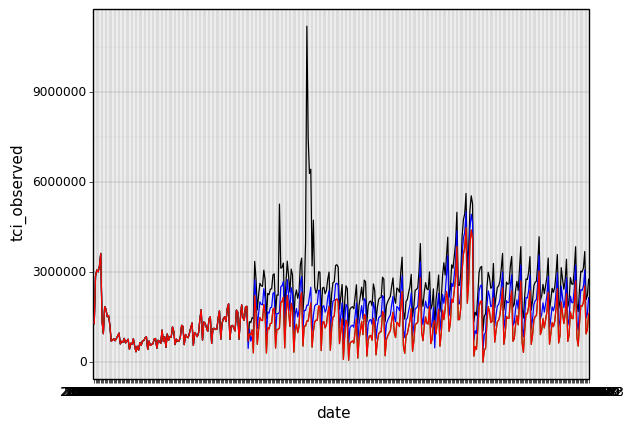

<ggplot: (8793651377749)>

In [157]:
gg = (p9.ggplot(df_union[df_union.region_slug == 'aguascalientes'],
                    p9.aes(x = 'date', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tci_min'), color = 'blue')
 + p9.geom_line(p9.aes( y='tci_max'), color = 'green')
 + p9.geom_line(p9.aes( y='tci_avg'), color = 'red'))
gg

### Weekly

In [131]:
df_min = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_min.csv")
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max.csv")
df_avg = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_avg.csv")

df_max = df_max[['week', 'year', 'date_min', 'date_max', 'region_slug', 
                 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_max', 
                       'tcp_clean':'tcp_max'}) 
df_min = df_min[['week', 'year', 'date_min', 'date_max', 'region_slug', 
                 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_min', 
                       'tcp_clean':'tcp_min'})
df_avg = df_avg[['week', 'year', 'date_min', 'date_max', 'region_slug', 
                 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_avg', 
                       'tcp_clean':'tcp_avg'})

In [132]:
print(df_min.shape)
print(df_max.shape)
print(df_avg.shape)

(4536, 9)
(4536, 9)
(4536, 9)


In [129]:
df_union = df_max \
    .merge(df_avg) \
    .merge(df_min)
df_union.describe()

,week,year,tci_observed,tcp_observed,tci_max,tcp_max,tci_avg,tcp_avg,tci_min,tcp_min
count,4536.000000,4536.000000,4.536000e+03,4536.000000,4.536000e+03,4536.000000,4.536000e+03,4536.000000,4.536000e+03,4536.000000
mean,26.910714,2020.232143,2.626892e+08,-37.733076,1.680824e+08,-51.997233,1.686017e+08,-52.006221,1.670346e+08,-52.154047
std,15.561826,0.422246,1.013355e+09,42.592507,4.460569e+08,29.789892,4.477566e+08,29.960983,4.446560e+08,29.809193
min,1.000000,2020.000000,1.082540e+05,-98.652182,0.000000e+00,-100.000000,0.000000e+00,-100.000000,0.000000e+00,-100.000000
25%,12.750000,2020.000000,1.570026e+07,-67.983581,1.180077e+07,-72.101521,1.198378e+07,-72.058849,1.193663e+07,-72.082702
50%,26.500000,2020.000000,5.006796e+07,-41.567663,3.891242e+07,-55.511338,3.819482e+07,-56.143140,3.883561e+07,-56.721505
75%,40.250000,2020.000000,1.382726e+08,-16.456545,1.178461e+08,-37.541943,1.158904e+08,-38.003545,1.166094e+08,-36.973610
max,53.000000,2021.000000,1.931785e+10,469.449876,6.990500e+09,187.372249,6.990500e+09,187.372249,6.990500e+09,187.372249


In [130]:
df_union.to_csv("/home/soniame/private/weekly_weekly_index.csv")

In [46]:
#plt.scatter(df.tcp, df.tcp_clean)
#df[['date', 'region_slug', 'tcp_clean']] 

In [26]:
df.region_slug.unique()[:5]

array(['aguascalientes', 'arequipa', 'barranquilla', 'belem',
       'belohorizonte'], dtype=object)

In [27]:
(df
 >> group_by('region_slug')
 >> summarize(min_tcp = _.tcp_clean.abs().min(),
              max_tcp = _.tcp_clean.abs().max(), 
              min_baseline = _.expected_2020.abs().min()/1e6,
              max_baseline = _.expected_2020.abs().max()/1e6,
              min_observed = _.observed.abs().min()/1e6,
              max_observed = _.observed.abs().max()/1e6,
              min_cleaned = _.S2_shift.abs().min()/1e6,
              max_cleaned = _.S2_shift.abs().max()/1e6
              )
 >> arrange(_.max_tcp)
).tail(15)

,region_slug,min_tcp,max_tcp,min_baseline,max_baseline,min_observed,max_observed,min_cleaned,max_cleaned
89,salvador,0.955091,160.335981,4.209501,31.798256,1.033705,33.612018,0.000000,32.490504
19,br_states_para,1.068860,170.844129,9.000050,23.627700,3.268988,90.694202,0.000000,40.125359
63,goiania,0.153919,175.496310,4.140577,21.031585,1.818340,25.539758,1.818340,19.271350
86,recife,0.893988,179.317727,10.753839,39.785849,2.298246,56.431478,0.000000,41.155948
73,manaus,0.160825,188.531483,4.711394,23.069681,1.474063,43.855084,0.000000,27.639117
61,curitiba,1.667522,214.583228,4.647760,28.106101,1.933182,44.337458,0.000000,23.919793
23,br_states_piaui,0.119268,219.441937,4.930524,9.167334,1.396007,38.790136,1.396007,21.061958
16,br_states_mato_grosso,0.016030,232.333721,7.124668,13.122494,2.878925,186.420794,0.000000,34.327946
17,br_states_mato_grosso_do_sul,1.114828,251.576359,7.963288,14.359315,3.396957,115.992726,0.000000,46.248651
28,br_states_roraima,0.023093,267.902111,0.714164,1.291361,0.286453,5.656422,0.000000,3.368264


#### Step run

In [ ]:
df_cty = _load_data()

In [ ]:
df_run_1 = _run_step(df_run = df_cty[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
df_run_1.head()

In [ ]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
qry = """
select 
    *
from spd_sdv_waze_corona.prod_daily_weekly_index
limit 10
"""
df = pd.read_sql_query(qry, conn)

In [ ]:
df.columns #sort_values('week_number')

In [17]:
import pandas as pd
metadata = pd.read_csv("http://tiny.cc/idb-traffic-metadata")

In [23]:
print(len(metadata.region_slug))
print(metadata.region_slug.unique())

metadata.head()

139
['country_guatemala' 'barranquilla' 'buenosaires' 'caracas'
 'br_states_maranhao' 'maracay' 'country_dominican_republic' 'saopaulo'
 'manaus' 'br_states_minas_gerais' 'montevideo' 'merida' 'ciudad_guayana'
 'br_states_amazonas' 'lapaz' 'country_peru' 'sanpedrosula'
 'country_argentina' 'br_states_rio_de_janeiro' 'cordoba'
 'country_el_salvador' 'bucaramanga' 'tijuana' 'medellin'
 'br_states_mato_grosso' 'maceio' 'br_states_pernambuco' 'guayaquil'
 'br_states_paraiba' 'country_nicaragua' 'santodomingo' 'panamacity'
 'sanfernado' 'arequipa' 'country_uruguay' 'guatemala' 'natal'
 'sanluispotosi' 'georgetown' 'br_states_santa_catarina' 'santamarta'
 'sansalvador' 'juarez' 'br_states_para' 'salvador' 'br_states_alagoas'
 'br_states_espirito_santo' 'tegucigalpa' 'country_costa_rica'
 'br_states_bahia' 'bridgetown' 'riodejaneiro' 'cucuta' 'br_states_amapa'
 'toluca' 'bogota' 'managua' 'country_honduras' 'queretaro'
 'br_states_piaui' 'leon' 'country_paraguay' 'country_guyana'
 'country_ja

,country_name,country_iso,region_slug,region_name,region_type,population,timezone,region_shapefile_wkt,osm_length,daily_coef_var,...,daily_coef_var_weekday,weekend_osm_ratio,weekday_osm_ratio,daily_approved,weekly_approved,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,Guatemala,GT,country_guatemala,Guatemala,country,17915567.0,America/Guatemala,MULTIPOLYGON (((-92.2393264773401 14.541251788...,5.664239e+07,0.257001,...,0.253105,0.958859,1.153470,True,True,NaN,NaN,NaN,NaN,NaN
1,Colombia,CO,barranquilla,Barranquilla,city,1931750.0,America/Bogota,POLYGON ((-74.83374991971161 11.04958488300598...,2.609151e+06,0.316392,...,0.346008,3.327034,4.944916,True,True,NaN,NaN,NaN,NaN,NaN
2,Argentina,AR,buenosaires,Buenos Aires,city,14338718.0,America/Argentina/Buenos_Aires,POLYGON ((-58.75041764050466 -34.3670848864218...,3.033681e+07,0.326066,...,0.423715,1.914411,2.969939,True,True,NaN,NaN,NaN,NaN,NaN
3,Venezuela,VE,caracas,Caracas,city,2408266.0,America/Caracas,POLYGON ((-67.00833333335606 10.39999999997973...,3.187649e+06,0.758516,...,1.737158,0.571506,1.639975,False,False,NaN,NaN,NaN,NaN,NaN
4,Brasil,BR,br_states_maranhao,Maranhao,state,NaN,NaN,POLYGON ((-45.84073319904228 -1.04548473090940...,7.803499e+07,0.355675,...,0.421830,0.376916,0.475001,True,True,NaN,NaN,NaN,NaN,NaN


In [31]:
metadata[metadata.region_slug == 'mexicocity'].region_shapefile_wkt.to_list()

['POLYGON ((-99.22541498771096 19.79958548078565, -99.19208165656235 19.79958548078565, -99.17541499098803 19.77458547907771, -99.15041499262657 19.77458547907771, -99.15041499262657 19.73291880956447, -99.12541499426511 19.73291880956447, -99.10041499590365 19.70791880785653, -99.06708166475504 19.71625214175918, -99.06708166475504 19.69125214005124, -98.99208166967065 19.70791880785653, -98.96708167130919 19.74125214346712, -98.92541500737342 19.69958547395388, -98.95041500573488 19.69125214005124, -98.95874833852204 19.65791880444065, -98.97541500409635 19.65791880444065, -98.96708167130919 19.63291880273271, -98.94208167294772 19.63291880273271, -98.91708167458627 19.65791880444065, -98.8754150106505 19.649585470538, -98.88374834343765 19.63291880273271, -98.90874834179911 19.63291880273271, -98.88374834343765 19.61625213492741, -98.89208167622481 19.59125213321947, -98.85041501228903 19.54125212980358, -98.85041501228903 19.49958546029035, -98.8754150106505 19.47458545858241, -98.